In [78]:
import tensorflow as tf
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from IPython.display import Image

In [33]:
base_dir = '../input/cat-and-dog'

train_dir = os.path.join(base_dir, 'training_set/training_set')
validation_dir = os.path.join(base_dir, 'test_set/test_set')

# Directory with our training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cats_dir,train_dogs_dir,validation_cats_dir,validation_dogs_dir

('../input/cat-and-dog/training_set/training_set/cats',
 '../input/cat-and-dog/training_set/training_set/dogs',
 '../input/cat-and-dog/test_set/test_set/cats',
 '../input/cat-and-dog/test_set/test_set/dogs')

In [35]:
img = cv2.imread(train_cats_dir+"/cat.1.jpg", cv2.IMREAD_UNCHANGED)
img.shape

(280, 300, 3)

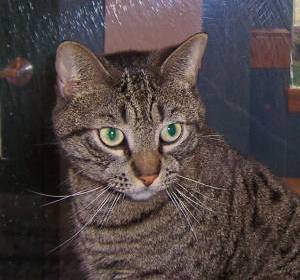

In [82]:
Image(filename=train_cats_dir+"/cat.1.jpg", width= 150, height=150)

In [36]:
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )

print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

['cat.2271.jpg', 'cat.728.jpg', 'cat.472.jpg', 'cat.2725.jpg', 'cat.1951.jpg', 'cat.562.jpg', 'cat.2185.jpg', 'cat.2000.jpg', 'cat.3504.jpg', 'cat.3065.jpg']
['dog.648.jpg', 'dog.1845.jpg', 'dog.3340.jpg', 'dog.1610.jpg', 'dog.94.jpg', 'dog.1717.jpg', 'dog.1229.jpg', 'dog.3910.jpg', 'dog.2837.jpg', 'dog.2282.jpg']


In [37]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

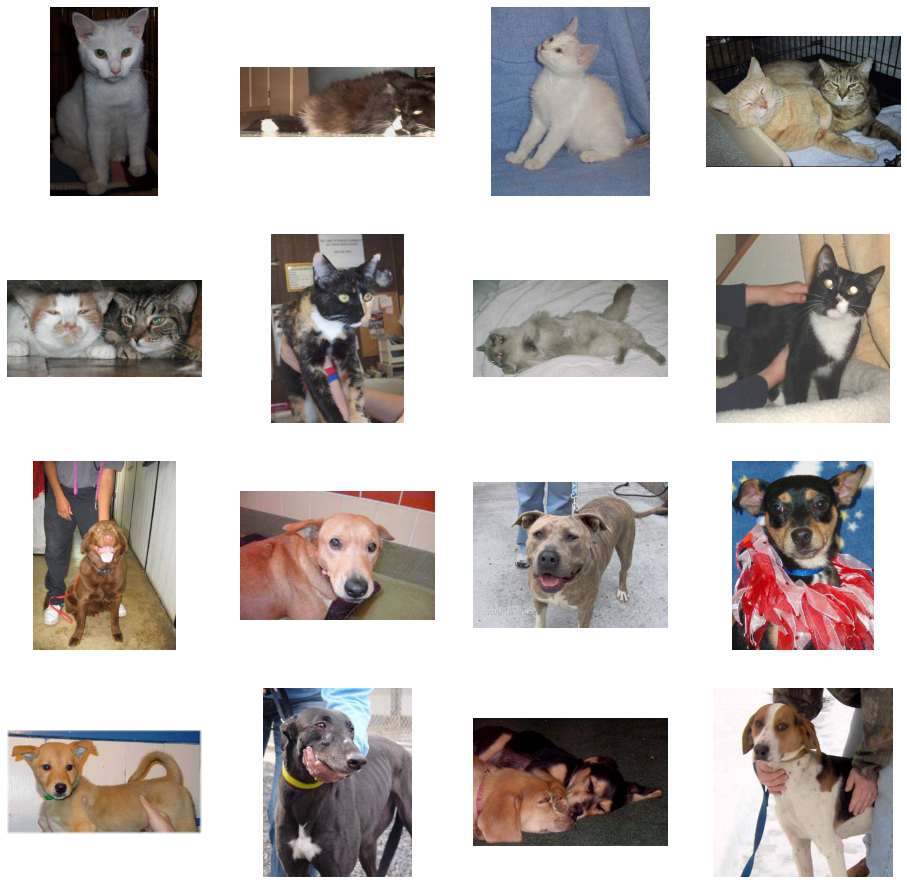

In [38]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


In [40]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

In [41]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18496)            

In [45]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [44]:
training_datagen = ImageDataGenerator(rescale=1./255)
train_generator = training_datagen.flow_from_directory(
    train_dir,
    target_size = (150,150),
    batch_size = 20,
    class_mode = "binary"
)

valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow_from_directory(
    validation_dir,
    target_size = (150,150),
    batch_size = 20,
    class_mode = "binary"
)

Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


In [48]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.95):
            print("\nReached 95% accuracy so cancelling training!")
            self.model.stop_training = True
callbacks= myCallback()

In [86]:
model.output_shape

(None, 1)

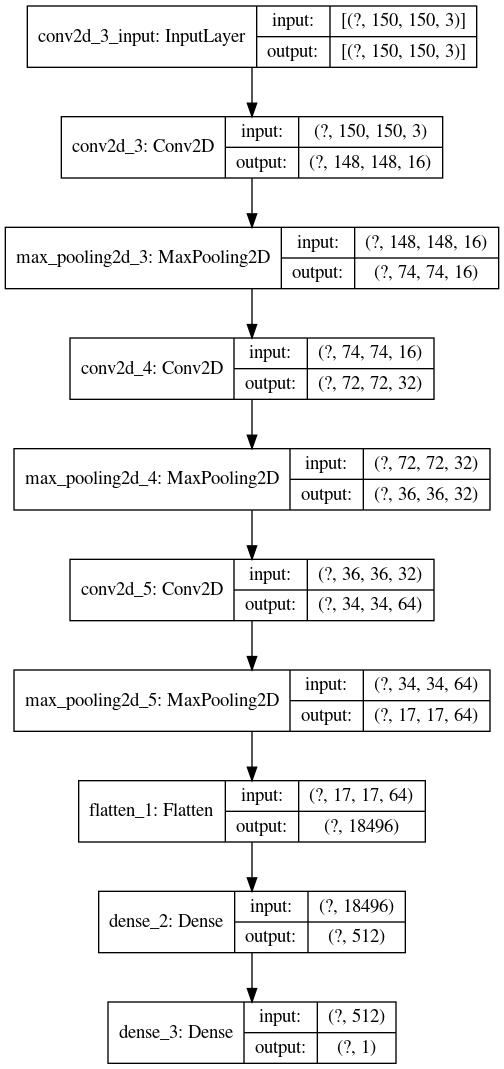

In [88]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [50]:
history = model.fit(train_generator,
                              validation_data=valid_generator,
                              steps_per_epoch=100,
                              epochs=15,
                              validation_steps=50,
                              verbose=2,
                              callbacks = [callbacks])

Epoch 1/15
100/100 - 15s - loss: 0.6936 - accuracy: 0.5955 - val_loss: 0.6516 - val_accuracy: 0.6590
Epoch 2/15
100/100 - 14s - loss: 0.6335 - accuracy: 0.6620 - val_loss: 0.5928 - val_accuracy: 0.6940
Epoch 3/15
100/100 - 12s - loss: 0.5972 - accuracy: 0.6965 - val_loss: 0.5840 - val_accuracy: 0.6980
Epoch 4/15
100/100 - 12s - loss: 0.5850 - accuracy: 0.7010 - val_loss: 0.5742 - val_accuracy: 0.7300
Epoch 5/15
100/100 - 11s - loss: 0.5638 - accuracy: 0.7170 - val_loss: 0.5338 - val_accuracy: 0.7190
Epoch 6/15
100/100 - 11s - loss: 0.5295 - accuracy: 0.7395 - val_loss: 0.5253 - val_accuracy: 0.7400
Epoch 7/15
100/100 - 12s - loss: 0.4986 - accuracy: 0.7620 - val_loss: 0.5845 - val_accuracy: 0.6960
Epoch 8/15
100/100 - 11s - loss: 0.4752 - accuracy: 0.7685 - val_loss: 0.5608 - val_accuracy: 0.7410
Epoch 9/15
100/100 - 10s - loss: 0.4417 - accuracy: 0.7980 - val_loss: 0.4649 - val_accuracy: 0.7800
Epoch 10/15
100/100 - 11s - loss: 0.4298 - accuracy: 0.7985 - val_loss: 0.5467 - val_accura

In [91]:
doge = "../input/testdata/unnamed.jpg"
img = cv2.imread(doge, cv2.IMREAD_UNCHANGED)
img = cv2.resize(img,(150,150))
fn= os.listdir("../input/testdata")
img.shape,fn

((150, 150, 3), ['unnamed.jpg'])

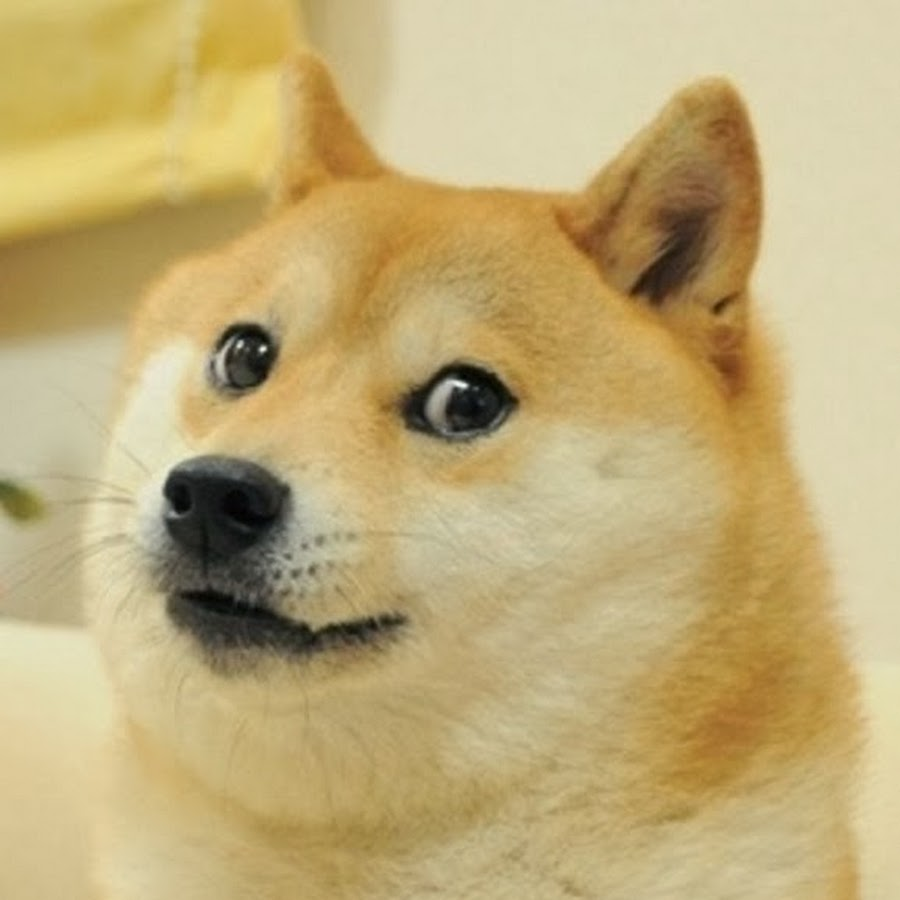

In [92]:
Image(filename=doge, width= 150, height=150)

In [75]:
import numpy as np

from keras.preprocessing import image
# predicting images
x=image.img_to_array(img)
x=np.expand_dims(x, axis=0)
images = np.vstack([x])
classes = model.predict(images, batch_size=10)
print(classes[0])
if classes[0]>0:
    print(str(fn)+ " is a dog")
else:
    print(str(fn) + " is a cat")
 

[1.]
['unnamed.jpg'] is a dog


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


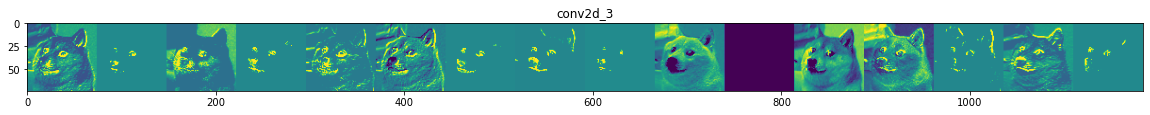

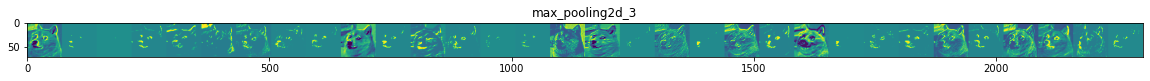

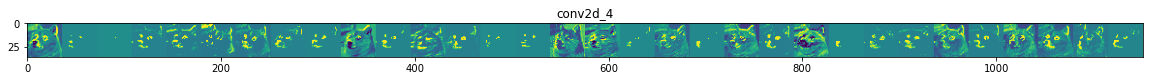

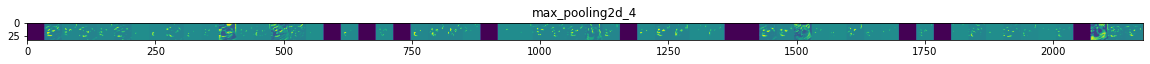

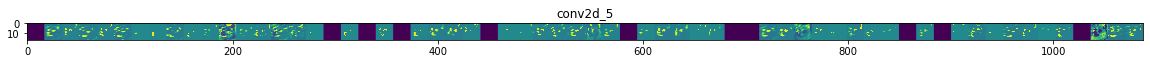

In [94]:
import random
from   tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]

#img_path = random.choice(cat_img_files + dog_img_files)
img_path = doge
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image

x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

Text(0.5, 1.0, 'Training and validation loss')

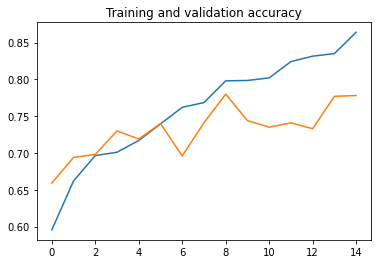

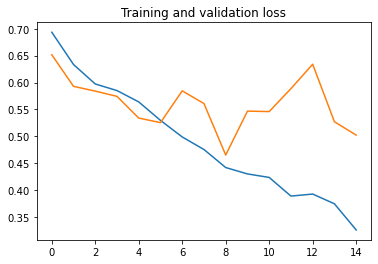

In [90]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )